In [4]:
%cd /home/is/dwipraseetyo-a/NAS_HAI/Project/Qwen2.5-Omni
%pwd

import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0, 1"
print("CUDA_VISIBLE_DEVICES:", os.environ["CUDA_VISIBLE_DEVICES"])

import torch
device_name = torch.cuda.get_device_name(0)
for i in range(torch.cuda.device_count()):
    props = torch.cuda.get_device_properties(i)
    print(f"Logical index: {i}, Name: {props.name}")

import pickle, os, re, random
from PIL import Image
from tqdm import tqdm
import numpy as np

import torch
from torch.utils.data import DataLoader
from qwen_omni_utils import process_mm_info
from my_qwenwrapper import get_OmniModel, get_stoppingcrit

import commons
import const_variable
from my_datasets import QwenOmniFinetuneDataset

os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

def get_label_fromprompt(text):
    match = re.search(r"## 🧠 Overview\n(.*?)\n\n##", text, re.DOTALL)
    sentence = match.group(1).strip() if match else None
    if sentence in const_variable.positive_templates:
        return 1
    elif sentence in const_variable.negative_templates:
        return 0
    else: 
        return random.randint(2, 5)

/home/ldap-users-2/dwipraseetyo-a/Project/Qwen2.5-Omni
CUDA_VISIBLE_DEVICES: 0, 1
Logical index: 0, Name: NVIDIA GeForce RTX 3090
Logical index: 1, Name: NVIDIA GeForce RTX 3090


In [5]:
adapter_path = "outputs/qwen25omni-3b-instructMedic-reasonllm-notallpresent-trl-sft-sentencetrans/checkpoint-500"
model, processor = get_OmniModel(model_path="Qwen/Qwen2.5-Omni-3B", processor_path="Qwen/Qwen2.5-Omni-3B", adapter_path=adapter_path, 
                                 use_flash_attention=True, only_processor=False, quantize_4bit=False, offload_folder="offload", set_eval=True)

# processor = get_OmniModel(model_path="Qwen/Qwen2.5-Omni-3B", processor_path="Qwen/Qwen2.5-Omni-3B", adapter_path=adapter_path, 
#                                   use_flash_attention=True, only_processor=True, quantize_4bit=True, offload_folder="offload", set_eval=True)

stopping_criteria = get_stoppingcrit(processor)

def collateevaluate_fn(conversations):
    for conv in conversations:
        del conv[2]
        
    text =  [processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False) for conversation in conversations]
    audios, images, videos = process_mm_info(conversations, use_audio_in_video=False)
    batch = processor(text=text, audio=audios, images=images, videos=videos, 
                            return_tensors="pt", padding=True, use_audio_in_video=False)
    
    labels = batch["input_ids"].clone()
    labels[labels == processor.tokenizer.pad_token_id] = -100

    # Ignore the image token index in the loss computation (model specific)
    image_tokens = [151652, 151653, 151655]
    audio_tokens = [151647, 151648, 151646]

    # Mask image token IDs in the labels
    for image_token_id in image_tokens:
        labels[labels == image_token_id] = -100  # Mask image token IDs in labels

    for audio_token_id in audio_tokens:
        labels[labels == audio_token_id] = -100  # Mask image token IDs in labels

    batch['use_audio_in_video'] = False
    return batch

Loading Model.... Using Offload Folder
Loading Model.... Using Flash Attention


Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

/home/is/dwipraseetyo-a/.venv/lib/python3.12/site-packages/awq/__init__.py:21: DeprecationWarning: 
I have left this message as the final dev message to help you transition.

Important Notice:
- AutoAWQ is officially deprecated and will no longer be maintained.
- The last tested configuration used Torch 2.6.0 and Transformers 4.51.3.
- If future versions of Transformers break AutoAWQ compatibility, please report the issue to the Transformers project.

Alternative:
- AutoAWQ has been adopted by the vLLM Project: https://github.com/vllm-project/llm-compressor

For further inquiries, feel free to reach out:
- X: https://x.com/casper_hansen_
- LinkedIn: https://www.linkedin.com/in/casper-hansen-804005170/

  warnings.warn(_FINAL_DEV_MESSAGE, category=DeprecationWarning, stacklevel=1)


In [6]:
with open('datas/positive_instruct.pkl.test', 'rb') as f:
    dev_instruct = pickle.load(f)
dev_instruct = commons.load_image_PIL(dev_instruct[:25])
dev_dataset = QwenOmniFinetuneDataset(dev_instruct, processor, use_audio_in_video=False)
print(dev_dataset[0])

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25/25 [00:00<00:00, 68.81it/s]

[{'role': 'system', 'content': [{'type': 'text', 'text': '\nYou are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions, capable of perceiving auditory and visual inputs. \nYou can interpret and reason over various medical inputs, including auditory inputs, visual inputs, and patient symptoms, individually or in combination, depending on what is provided. \nYour task is to analyze the given input, explain your reasoning, and give a possible diagnosis. \nAlways respond in the following format:\n\n## ⚠️ Points to Review and Disclaimer\n<If no auditory or visual input is provided>\n\n## 🧠 Overview\n<Diagnosis sentence>\n\n## 📋 Observations\n**Chest X-ray:**\n<Your explanation based on the relevant visual input>"\n\n**Symptoms:**\n<Your explanation based on the input symptoms>"\n\n**Audio:**\n<Your explanation based on the input audio>"\n'}]}, {'role': 'user', 'content': [{'type': 'text', 'text': 'Considering all inputs image, sound, and symptoms, i

In [7]:
test_loader = DataLoader(dev_dataset,
    batch_size=1, shuffle=True, collate_fn=collateevaluate_fn
)

In [12]:
for batch in tqdm(test_loader):
    batch = {
        k: (v.to(model.device).to(model.dtype) if v.dtype.is_floating_point else v.to(model.device))
        if torch.is_tensor(v) else v
        for k, v in batch.items()
    }
    with torch.no_grad(), torch.amp.autocast('cuda'):
        generation = model.generate(
            **batch,
            stopping_criteria=stopping_criteria,
            max_new_tokens=768,
        )
        generate_ids = generation[:, batch["input_ids"].size(1):]

    decoded = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)
    del generation, generate_ids, batch
    torch.cuda.empty_cache()
    torch.cuda.ipc_collect()
    break

print(decoded[0])

  0%|                                                                                                                                                                                                                 | 0/25 [00:16<?, ?it/s]

From the provided symptoms and cough duration, Let me analyze your regrading your questions.

## 🧠 Overview
No, this is not a case of Tuberculosis (TB).

## 📋 Observations
**Symptoms:**
* The patient has a cough duration of more than 4 weeks, which is suggestive of a chronic respiratory condition. However, the absence of hemoptysis, fever, night sweats, and shortness of breath are key negative indicators for TB. Additionally, the patient's weight loss is a significant symptom, but it can be associated with various other conditions, including malnutrition, malignancies, or chronic infections. The patient's negative HIV status further reduces the likelihood of TB, as HIV-positive individuals are at a higher risk for developing TB. Therefore, while the symptoms are concerning, they do not strongly support a diagnosis of TB.

**Audio:**
* No audio is provided.


In [48]:
from sentence_transformers import SentenceTransformer, util
import torch

# Load embedding model once
embedder = SentenceTransformer('all-MiniLM-L6-v2')

# Precompute embeddings for templates
positive_templates = const_variable.positive_templates
negative_templates = const_variable.negative_templates

pos_embeds = embedder.encode(positive_templates, convert_to_tensor=True)
neg_embeds = embedder.encode(negative_templates, convert_to_tensor=True)

/home/is/dwipraseetyo-a/.venv/lib/python3.12/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `BertSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)


In [49]:
def get_label_fromprompt(text, threshold=0.7):
    match = re.search(r"## 🧠 Overview\s*(.*?)\s*(##|$)", text, re.DOTALL)
    sentence = match.group(1).strip() if match else None

    # Compute embedding for sentence
    sent_embed = embedder.encode(sentence, convert_to_tensor=True)

    # Compute cosine similarities
    pos_sim = util.cos_sim(sent_embed, pos_embeds)  # shape: (1, N_pos)
    neg_sim = util.cos_sim(sent_embed, neg_embeds)  # shape: (1, N_neg)

    mean_pos_sim = pos_sim.mean().item()
    mean_neg_sim = neg_sim.mean().item()
    
    if mean_pos_sim >= threshold and mean_pos_sim > mean_neg_sim:
        return 1
    elif mean_neg_sim >= threshold and mean_neg_sim > mean_pos_sim:
        return 0
    else:
        return random.randint(2, 5)

In [50]:
get_label_fromprompt(decoded[0])

0

In [ ]:
import pickle, os, copy, random
from PIL import Image
from tqdm import tqdm
import numpy as np
import pickle
import librosa
from IPython.display import Audio, Markdown, display
import matplotlib.pyplot as plt
import re
import const_variable

import torch
import torch.nn.functional as F
from torch.utils.data import Dataset
from transformers import StoppingCriteria, StoppingCriteriaList, Qwen2_5OmniThinkerForConditionalGeneration, Qwen2_5OmniProcessor, BitsAndBytesConfig
from qwen_omni_utils import process_mm_info

class StopOnMultiToken(StoppingCriteria):
    def __init__(self, stop_token_ids):
        self.stop_token_ids = stop_token_ids  # list of ints
        self.sequence_length = len(stop_token_ids)

    def __call__(self, input_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs):
        if input_ids.shape[1] < self.sequence_length:
            return False  # too early to match

        # Check if last N tokens match the stop sequence
        return input_ids[0, -self.sequence_length:].tolist() == self.stop_token_ids

def load_image_PIL(loaded_object):
    for obj in tqdm(loaded_object):
        for message in obj.get("messages", []):
            for content in message.get("content", []):
                if isinstance(content, dict) and "image" in content:
                    array = np.load(content["image"])
                    array_min = array.min()
                    array_max = array.max()
                    if array_max != array_min:
                        array_norm = (array - array_min) / (array_max - array_min)
                    else:
                        array_norm = np.zeros_like(array)
                    array_uint8 = (array_norm * 255).astype(np.uint8)
                    mask = array_uint8 != 253
                    coords = np.argwhere(mask)
                    if coords.size == 0:
                        cropped_array = array_uint8
                    else:
                        y0, x0 = coords.min(axis=0)
                        y1, x1 = coords.max(axis=0) + 1
                        cropped_array = array_uint8[y0:y1, x0:x1]
                    array_PIL = Image.fromarray(cropped_array)
                    content["image"] = array_PIL
    return loaded_object

class QwenOmniInferenceDataset(Dataset):
    def __init__(self, data, processor, use_audio_in_video=False):
        self.data = data
        self.processor = processor
        self.use_audio_in_video = use_audio_in_video

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        conversation = self.data[idx]#["messages"]
        for message in conversation.get("messages", []):
            for content in message.get("content", []):
                if isinstance(content, dict) and "image" in content:
                    array = np.load(content["image"])
                    array_min = array.min()
                    array_max = array.max()
                    if array_max != array_min:
                        array_norm = (array - array_min) / (array_max - array_min)
                    else:
                        array_norm = np.zeros_like(array)
                    array_uint8 = (array_norm * 255).astype(np.uint8)
                    mask = array_uint8 != 253
                    coords = np.argwhere(mask)
                    if coords.size == 0:
                        cropped_array = array_uint8
                    else:
                        y0, x0 = coords.min(axis=0)
                        y1, x1 = coords.max(axis=0) + 1
                        cropped_array = array_uint8[y0:y1, x0:x1]
                    array_PIL = Image.fromarray(cropped_array)
                    content["image"] = array_PIL
        return conversation["messages"]

/home/is/dwipraseetyo-a/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_compute_dtype=torch.float16,
    bnb_4bit_use_double_quant=True,
    bnb_4bit_quant_type="nf4",
)

thinker = Qwen2_5OmniThinkerForConditionalGeneration.from_pretrained("Qwen/Qwen2.5-Omni-3B",
            torch_dtype="auto",
            device_map="auto",  
            quantization_config=bnb_config, 
            attn_implementation="flash_attention_2",
            offload_folder="offload", # Offload weights to CPU if needed
        )
thinker.eval()
processor = Qwen2_5OmniProcessor.from_pretrained("Qwen/Qwen2.5-Omni-3B")

stop_token = "<|im_end|>"
stop_token_ids = processor(stop_token, add_special_tokens=False)["input_ids"][0]
stopping_criteria = StoppingCriteriaList([StopOnMultiToken(stop_token_ids)])

Unrecognized keys in `rope_scaling` for 'rope_type'='default': {'mrope_section'}
You are attempting to use Flash Attention 2 without specifying a torch dtype. This might lead to unexpected behaviour
Loading checkpoint shards: 100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:02<00:00,  1.48it/s]
The image processor of type `Qwen2VLImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. Note that this behavior will be extended to all models in a future release.
You have video processor config saved in `preprocessor.json` file which is deprecated. Video processor configs should be saved in their own `video_preprocessor.json` file. Y

In [4]:
def format_params(n):
    if n >= 1_000_000_000:
        return f"{n / 1_000_000_000:.2f}B"
    elif n >= 1_000_000:
        return f"{n / 1_000_000:.2f}M"
    elif n >= 1_000:
        return f"{n / 1_000:.2f}K"
    else:
        return str(n)

audio_tower_params = sum(p.numel() for p in thinker.audio_tower.parameters())
visual_tower_params = sum(p.numel() for p in thinker.visual.parameters())
model_tower_params = sum(p.numel() for p in thinker.model.parameters())

print(f"Total parameters in audio_tower: {format_params(audio_tower_params)}")
print(f"Total parameters in visual_tower: {format_params(visual_tower_params)}")
print(f"Total parameters in model_tower: {format_params(model_tower_params)}")

Total parameters in audio_tower: 321.79M
Total parameters in visual_tower: 335.35M
Total parameters in model_tower: 1.70B


In [5]:
with open('/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/instruct.pkl.test', 'rb') as f:
    test_instruct = pickle.load(f) #load_image_PIL()
test_dataset = QwenOmniInferenceDataset(test_instruct, processor, use_audio_in_video=False)

In [168]:
conversation = copy.deepcopy(test_dataset[random.randint(0, len(test_dataset))])

In [ ]:
def get_label_fromprompt(text):
    match = re.search(r"## 🧠 Overview\n(.*?)\n\n##", text, re.DOTALL)
    sentence = match.group(1).strip() if match else None
    if sentence in const_variable.positive_templates:
        return 1
    elif sentence in const_variable.negative_templates:
        return 0
    else:
        return random.randint(2, 5)

get_label_fromprompt(conversation[-1]['content'][0]['text'])

0

In [169]:
conversation

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions. You can interpret and reason over various medical inputs, including cough sounds, chest X-rays, and patient metadata, individually or in combination, depending on what is provided. Your task is to analyze the given information, explain your reasoning clearly, and provide possible diagnoses based on medical understanding. Support your conclusions with observations from the input data whenever possible, and maintain clinical accuracy and clarity in your responses.'}]},
 {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Analyze the patient symptoms and cough, could this be TB?.  Also, the patient presents with: haemoptysis is no, tobacco use is never, bmi is 32.0, cough duration is <1wk, shortbreath is no, hiv status is neg, chestpain is yes, sex is f, night sweets is no, height is 153.0, weight loss is no, fever i

In [177]:
conversation[0]['content'][0] = {'type': 'text',
'text': "You are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions, capable of perceiving auditory and visual inputs. You can interpret and reason over various medical inputs, including auditory inputs, visual inputs, and patient symptoms, individually or in combination, depending on what is provided. Your task is to analyze the given input, explain your reasoning, and give a possible diagnosis.\n\n Always respond in the following format:\n\n ## 🧠 Overview\n<Diagnosis sentence>\n\n ## 📋 Observations\n<Your explanation based on the cough sound, symptoms, or relevant visual input.>  \n\n ## ⚠️ Points to Review and Disclaimer\n <If no auditory or visual input is provided.>."}

In [171]:
conversation[1]['content'][0] = {'type': 'text',
'text': "Diagnose the disease?."}
# "Do you known what is the sound and image i given to you?. and approximately what disease is that?."

In [139]:
conversation[1]['content'][2]['audio'] = '/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/wavs/01-399-0929.wav'

In [172]:
conversation

[{'role': 'system',
  'content': [{'type': 'text',
    'text': 'You are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions, capable of perceiving auditory and visual inputs. You can interpret and reason over various medical inputs, including auditory inputs, visual inputs, and patient symptoms, individually or in combination, depending on what is provided. Your task is to analyze the given input, explain your reasoning, and give a possible diagnosis.\n\n Always respond in the following format:\n\n ## 🧠 Overview\n<Diagnosis sentence>\n\n ## 📋 Observations\n<Your explanation based on the cough sound, symptoms, or relevant visual input.>  \n\n ## ⚠️ Points to Review and Disclaimer\n <Warn User If Auditory and Visual input not present.>.'}]},
 {'role': 'user',
  'content': [{'type': 'text', 'text': 'Diagnose the disease?.'},
   {'type': 'audio',
    'audio': '/home/is/dwipraseetyo-a/NAS_HAI/Datasets/cidrz/wavs/01-399-0837.wav'}]},
 {'role': 'assist

In [173]:
real_answer = conversation[2]
del conversation[2]

In [178]:
text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
audios, images, videos = process_mm_info(conversation, use_audio_in_video=False)
batch = processor(text=text, audio=audios, images=images, videos=videos, 
                        return_tensors="pt", padding=True, use_audio_in_video=False)
batch['use_audio_in_video'] = True
batch = batch.to(thinker.device).to(thinker.dtype)

In [179]:
print(text)
if images != None:
    plt.imshow(images[0])
    plt.show()
if audios != None:
    display(Audio(audios[0], rate=16000))

<|im_start|>system
You are an advanced medical assistant AI specialized in analyzing and diagnosing clinical conditions, capable of perceiving auditory and visual inputs. You can interpret and reason over various medical inputs, including auditory inputs, visual inputs, and patient symptoms, individually or in combination, depending on what is provided. Your task is to analyze the given input, explain your reasoning, and give a possible diagnosis.

 Always respond in the following format:

 ## 🧠 Overview
<Diagnosis sentence>

 ## 📋 Observations
<Your explanation based on the cough sound, symptoms, or relevant visual input.>  

 ## ⚠️ Points to Review and Disclaimer
 <If no auditory or visual input is provided.>.<|im_end|>
<|im_start|>user
Diagnose the disease?.<|audio_bos|><|AUDIO|><|audio_eos|><|im_end|>
<|im_start|>assistant



In [ ]:
with torch.no_grad(), torch.amp.autocast('cuda'):
    generation = thinker.generate(**batch, stopping_criteria=stopping_criteria, max_new_tokens=768) # do_sample=True, top_p = 1.0, top_k = 50, temperature=0.6
    generate_ids = generation[:, batch.input_ids.size(1):]
text_gen = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]

del generation, generate_ids, batch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
print(text_gen)

## 🧠 Overview
The patient is likely suffering from a respiratory infection, such as a cold or flu.

## 📋 Observations
The cough is characterized by a dry, hacking cough, which is a common symptom of respiratory infections. The coughing is not accompanied by any other symptoms, such as fever, shortness of breath, or chest pain, which would suggest a more severe condition like pneumonia or bronchitis. The coughing is also not productive, meaning that the cough is not followed by any expectoration of mucus or phlegm.

## ⚠️ Points to Review and Disclaimer
If the coughing is persistent or severe, or if the patient has other symptoms such as fever, shortness of breath, or chest pain, it is important to seek medical attention. Additionally, if the coughing is not productive, it is possible that the patient may have a viral infection, which can sometimes be difficult to differentiate from bacterial infections.


: 

{'role': 'assistant', 'content': [{'type': 'text', 'text': "From the given symptoms, cough sound, and x-ray, Let me Analyze your regrading your questions.\n\n*   All modalities are present.\nThis is a preliminary interpretation based on given data and does not replace a comprehensive clinical evaluation.. A definitive diagnosis requires a additional clinical evaluation, including the physical examination findings, Cough Sound, Auscultation Sound, and imaging studies.\n## 🧠 Overview\nno strong indications of Tuberculosis are found.\n\n## 📋 Observations\n**Symptoms:**\n*   The symptoms presented are indicative of a possible respiratory condition but do not align with the classic features of tuberculosis (TB). TB typically presents with a chronic cough lasting more than three weeks, often characterized by a productive cough that can include hemoptysis (coughing up blood). In this case, the cough duration is less than one week, which is too brief for TB, suggesting an acute process rather 

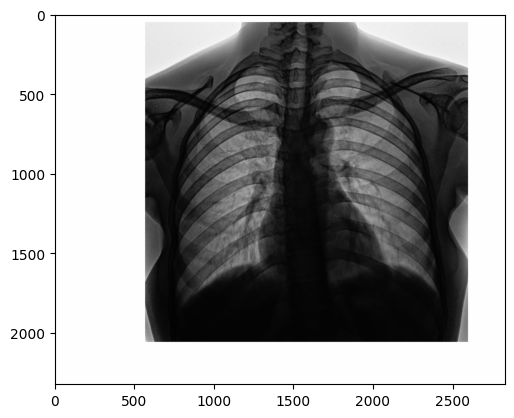

In [77]:
conversation = copy.deepcopy(test_dataset[random.randint(0, len(test_dataset))])
real_answer = conversation[2]
del conversation[2]#, conversation[1]['content'][2]#, conversation[1]['content'][2]
text = processor.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)
audios, images, videos = process_mm_info(conversation, use_audio_in_video=False)
batch = processor(text=text, audio=audios, images=images, videos=videos, 
                        return_tensors="pt", padding=True, use_audio_in_video=False)
batch['use_audio_in_video'] = True
batch = batch.to(thinker.device).to(thinker.dtype)

print(real_answer)
print(text)
if images != None:
    plt.imshow(images[0])
    plt.show()
if audios != None:
    display(Audio(audios[0], rate=16000))

In [76]:
with torch.no_grad(), torch.amp.autocast('cuda'):
    generation = thinker.generate(**batch, stopping_criteria=stopping_criteria, max_new_tokens=768) # do_sample=True, top_p = 1.0, top_k = 50, temperature=0.6
    generate_ids = generation[:, batch.input_ids.size(1):]
text_gen = processor.batch_decode(generate_ids, skip_special_tokens=True, clean_up_tokenization_spaces=True)[0]

del generation, generate_ids, batch
torch.cuda.empty_cache()
torch.cuda.ipc_collect()
display(Markdown(text_gen))

This case appears to be non-Tuberculosis.

In [78]:
display(Markdown(real_answer['content'][0]['text']))

From the given symptoms, cough sound, and x-ray, Let me Analyze your regrading your questions.

*   All modalities are present.
This is a preliminary interpretation based on given data and does not replace a comprehensive clinical evaluation.. A definitive diagnosis requires a additional clinical evaluation, including the physical examination findings, Cough Sound, Auscultation Sound, and imaging studies.
## 🧠 Overview
no strong indications of Tuberculosis are found.

## 📋 Observations
**Symptoms:**
*   The symptoms presented are indicative of a possible respiratory condition but do not align with the classic features of tuberculosis (TB). TB typically presents with a chronic cough lasting more than three weeks, often characterized by a productive cough that can include hemoptysis (coughing up blood). In this case, the cough duration is less than one week, which is too brief for TB, suggesting an acute process rather than a chronic infectious one. 

Additionally, while symptoms such as fever, night sweats, and weight loss can occur in TB patients, their presence alongside short cough duration and the absence of productive cough or hemoptysis leans the diagnosis away from TB. The patient's HIV-negative status and lack of risk factors such as tobacco use further reduce the likelihood of TB. Instead, these symptoms could point to other acute respiratory infections or conditions, such as viral bronchitis or pneumonia, which often manifest with rapid onset symptoms, chest pain, and dyspnea. Therefore, this case supports the conclusion that the patient does not have TB.

**Chest X-ray:**
* Specific Findings
    *   The lungs appear clear bilaterally, without evidence of consolidation, nodules, or masses.
    *   The heart size is within normal limits.
    *   The mediastinal contours are unremarkable.
    *   The hila are normal in appearance.
    *   The bony structures of the rib cage are intact.
    *   There is no evidence of pleural effusion or pneumothorax. 

* Differential Diagnosis
    *   None apparent based on this single image. 

Normal chest X-ray. 


**Audio:**
*   Will be Implemented Soon

In [16]:
print(text_gen)
print(real_answer['content'][0]['text'])

The diagnosis is likely not Tuberculosis.
From the given symptoms, cough sound, and x-ray, the patient probably does not have Tuberculosis.


In [64]:
def compute_token_accuracy(generated_text, reference_text):
    # Tokenize both
    gen_tokens = processor.tokenizer.encode(generated_text, add_special_tokens=False)
    ref_tokens = processor.tokenizer.encode(reference_text, add_special_tokens=False)

    # Truncate to same length
    min_len = min(len(gen_tokens), len(ref_tokens))
    gen_tokens = gen_tokens[:min_len]
    ref_tokens = ref_tokens[:min_len]

    # Compute token-wise accuracy
    correct = np.array(gen_tokens) == np.array(ref_tokens)
    accuracy = correct.sum() / len(correct)

    return accuracy

In [66]:
accuracy = compute_token_accuracy(text_gen, real_answer['content'][0]['text'])
print("Mean token accuracy:", accuracy)

Mean token accuracy: 0.14285714285714285


In [68]:
from bert_score import score

P = [text_gen]                # predicted
R = [real_answer['content'][0]['text']] # reference

P, R, F1 = score(P, R, lang="en", verbose=True)
print("BERTScore F1:", F1[0].item())

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


calculating scores...
computing bert embedding.


  0%|                                                                                                                                                              | 0/1 [00:00<?, ?it/s]/home/is/dwipraseetyo-a/ven2/lib/python3.10/site-packages/torch/nn/modules/module.py:1762: FutureWarning: `encoder_attention_mask` is deprecated and will be removed in version 4.55.0 for `RobertaSdpaSelfAttention.forward`.
  return forward_call(*args, **kwargs)
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.33it/s]


computing greedy matching.


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.79it/s]

done in 0.37 seconds, 2.71 sentences/sec
BERTScore F1: 0.9379073977470398
